# Tutorial (Structured Data Processing)

:::{warning}
This page is under construction and not finished yet. Do not use it.
:::

(Last updated: Feb 11, 2023)

This tutorial will familiarize you with the data science pipeline of processing structured data, using a real-world example of building models to predict and explain the presence of bad smell events in Pittsburgh using air quality and weather data. The models are used to send push notifications about bad smell events to inform citizens, as well as to explain local pollution patterns to inform stakeholders.


The scenario is in the next section of this tutorial, and more details are in the introduction section of the [Smell Pittsburgh paper](https://doi.org/10.1145/3369397). We will use the [same dataset as used in the Smell Pittsburgh paper](https://github.com/CMU-CREATE-Lab/smell-pittsburgh-prediction/tree/master/dataset/v1) as an example of structured data. During this tutorial, we will explain what the variables in the dataset mean and also guide you through model building.

You can use the following link to jump to the assignments:
- [Assignment for Task 4](#a4)
- [Assignment for Task 5](#a5)
- [Assignment for Task 6](#a6)

## Scenario

Local citizens in Pittsburgh are organizing communities to advocate for changes in air pollution regulations. Their goal is to investigate the air pollution patterns in the city to understand the potential sources related to the bad odor. The communities rely on the Smell Pittsburgh application (as indicated in the figure below) to collect smell reports from citizens that live in the Pittsburgh region. Also, there are air quality and weather monitoring stations in the Pittsburgh city region that provide sensor measurements, including common air pollutants and wind information.

\
<img src="../../../assets/images/smellpgh-ui.png" style="max-width: 700px;">

\
You work in a data science team to develop models to map the sensor data to bad smell events. Your team has been working with the Pittsburgh local citizens closely for a long time, and therefore you know the meaning of each variable in the feature set that is used to train the machine learning model. The Pittsburgh community needs your help timely to analyze the data that can help them present evidence of air pollution to the municipality and explain the patterns to the general public.

## Import Packages

We put all the packages that are needed for this tutorial below:

In [1]:
import pandas as pd
import numpy as np
import pytz
import seaborn as sns
import matplotlib.pyplot as plt
from os.path import isfile, join
from os import listdir
from pandas.api.indexers import FixedForwardWindowIndexer

## Task Answers

The code block below contains answers for the assignments in this tutorial. **Do not check the answers in the next cell before practicing the tasks.**

In [2]:
def check_answer_df(df_result, df_answer, n=1):
    """
    This function checks if two output dataframes are the same.
    
    Parameters
    ----------
    df_result : pandas.DataFrame
        The result from the output of a function.
    df_answer: pandas.DataFrame
        The expected output of the function.
    n : int
        The numbering of the test case.
    """
    try:
        assert df_answer.equals(df_result)
        print("Test case %d passed." % n)
    except:
        print("Test case %d failed." % n)
        print("")
        print("Your output is:")
        print(df_result)
        print("")
        print("Expected output is:")
        print(df_answer)

        
def answer_preprocess_sensor(df_list):
    """
    This function is the answer of task 5.
    Preprocess sensor data.
    
    Parameters
    ----------
    df_list : list of pandas.DataFrame
        A list of data frames that contain sensor data from multiple stations.
         
    Returns
    -------
    pandas.DataFrame
        The preprocessed sensor data.
    """
    # Resample all the data frames.
    df_resample_list = []
    for df in df_list:
        # Convert the timestamp to datetime.
        df.index = pd.to_datetime(df.index, unit="s", utc=True)
        # Resample the timestamps by hour and average all the previous values.
        # Because we want data from the past, so label need to be "right".
        df_resample_list.append(df.resample("60Min", label="right").mean())
    
    # Merge all data frames.
    df = df_resample_list.pop(0)
    index_name = df.index.name
    while len(df_resample_list) != 0:
        # We need to use outer merging since we want to preserve data from both data frames.
        df = pd.merge_ordered(df, df_resample_list.pop(0), on=df.index.name, how="outer", fill_method=None)
        # Move the datetime column to index
        df = df.set_index(index_name)

    # Fill in the missing data with value -1.
    df = df.fillna(-1)
    return df


def answer_preprocess_smell(df):
    """
    This function is the answer of task 4.
    Preprocess smell data.
    
    Parameters
    ----------
    df : pandas.DataFrame
        The raw smell reports data.
         
    Returns
    -------
    pandas.DataFrame
        The preprocessed smell data.
    """
    # Copy the dataframe to avoid editing the original one.
    df = df.copy(deep=True)
    
    # Drop the columns that we do not need.
    df = df.drop(columns=["feelings_symptoms", "smell_description", "zipcode"])
    
    # Select only the reports within the range of 3 and 5.
    df = df[(df["smell_value"]>=3)&(df["smell_value"]<=5)]
    
    # Convert the timestamp to datetime.
    df.index = pd.to_datetime(df.index, unit="s", utc=True)

    # Resample the timestamps by hour and sum up all the future values.
    # Because we want data from the future, so label need to be "left".
    df = df.resample("60Min", label="left").sum()
    
    # Fill in the missing data with value 0.
    df = df.fillna(0)
    return df


def answer_sum_current_and_future_data(df, n_hr=0):
    """
    This function is the answer of task 6.
    Sum up data in the current and future hours.
    
    Parameters
    ----------
    df : pandas.DataFrame
        The preprocessed smell data.
    n_hr : int
         Number of hours that we want to sum up the future smell data.
         
    Returns
    -------
    pandas.DataFrame
        The transformed smell data.
    """
    # Copy data frame to prevent editing the original one.
    df = df.copy(deep=True)
    
    # Fast return if n_hr is 0
    if n_hr == 0: return df
    
    # Sum up all smell_values in future hours.
    # The rolling function only works for summing up previous values.
    # So we need to shift back to get the value in the future.
    # Be careful that we need to add 1 to the rolling window size.
    # Becasue window size 1 means only using the current data.
    # Parameter "closed" need to be "right" because we want the current data.
    df = df.rolling(n_hr+1, min_periods=1, closed="right").sum().shift(-1*n_hr)
    
    # Below is an alternative implementation of rolling.
    #indexer = FixedForwardWindowIndexer(window_size=n_hr+1)
    #df = df.rolling(indexer, min_periods=1).sum()
    
    # Delete the last n_hr rows.
    # These n_hr rows have wrong data due to data shifting.
    df = df.iloc[:-1*n_hr]
    return df

## Task 4: Preprocess Sensor Data

In this task, we will process the sensor data from various air quality monitoring stations in Pittsburgh. You can find the list of sensors and their names (which will be in the data frame columns) from [this link](https://github.com/CMU-CREATE-Lab/smell-pittsburgh-prediction/tree/master/dataset/v2.1#description-of-the-air-quality-sensor-data). First, we need to load all the sensor data.

In [3]:
path = "../../../assets/datasets/smellpgh-v1/esdr_raw"
list_of_files = [f for f in listdir(path) if isfile(join(path, f))]
sensor_raw_list = []
for f in list_of_files:
    sensor_raw_list.append(pd.read_csv(join(path, f)).set_index("EpochTime"))

Now, the `sensor_raw_list` variable contains all the data frames with sensor values from different air quality monitoring stations. Noted that `sensor_raw_list` is an array of data frames. We can print one of them to take a look, as shown below. 

In [4]:
sensor_raw_list[0]

,3.feed_1.SO2_PPM,3.feed_1.H2S_PPM,3.feed_1.SIGTHETA_DEG,3.feed_1.SONICWD_DEG,3.feed_1.SONICWS_MPH
EpochTime,,,,,
1477891800,0.0,0.0,51.7,343.0,3.6
1477895400,0.0,0.0,52.7,351.0,3.5
1477899000,0.0,0.0,52.6,359.0,3.4
1477902600,0.0,0.0,48.3,5.0,2.1
1477906200,0.0,0.0,31.1,41.0,2.2
...,...,...,...,...,...
1538267400,0.0,0.0,35.2,39.0,1.7
1538271000,0.0,0.0,48.2,53.0,1.3
1538274600,0.0,0.0,30.9,62.0,1.5


Next, we need to resample and merge all the sensor data frames so that they can be used for modeling. Our goal is to have a dataframe that looks like the following:

In [5]:
df_sensor = answer_preprocess_sensor(sensor_raw_list)
df_sensor

,3.feed_1.SO2_PPM,3.feed_1.H2S_PPM,3.feed_1.SIGTHETA_DEG,3.feed_1.SONICWD_DEG,3.feed_1.SONICWS_MPH,3.feed_23.CO_PPM,3.feed_23.PM10_UG_M3,3.feed_29.PM10_UG_M3,3.feed_29.PM25_UG_M3,3.feed_11067.CO_PPB..3.feed_43.CO_PPB,...,3.feed_3.SO2_PPM,3.feed_3.SONICWD_DEG,3.feed_3.SONICWS_MPH,3.feed_3.SIGTHETA_DEG,3.feed_3.PM10B_UG_M3,3.feed_5975.PM2_5,3.feed_27.NO_PPB,3.feed_27.NOY_PPB,3.feed_27.CO_PPB,3.feed_27.SO2_PPB
EpochTime,,,,,,,,,,,,,,,,,,,,,
2016-10-31 06:00:00+00:00,0.0,0.0,51.7,343.0,3.6,0.2,7.0,8.0,8.0,159.5,...,0.0,344.0,2.9,43.0,9.0,0.0,0.1,2.6,-1.0,0.2
2016-10-31 07:00:00+00:00,0.0,0.0,52.7,351.0,3.5,0.2,8.0,8.0,8.0,-1.0,...,0.0,330.0,2.5,43.6,13.0,5.0,-1.0,-1.0,106.1,0.0
2016-10-31 08:00:00+00:00,0.0,0.0,52.6,359.0,3.4,0.2,5.0,7.0,7.0,133.0,...,0.0,0.0,3.1,40.9,7.0,9.0,0.2,2.1,105.8,-1.0
2016-10-31 09:00:00+00:00,0.0,0.0,48.3,5.0,2.1,0.2,3.0,4.0,4.0,236.6,...,0.0,325.0,1.9,40.0,11.0,3.0,0.1,3.1,111.7,0.0
2016-10-31 10:00:00+00:00,0.0,0.0,31.1,41.0,2.2,0.2,5.0,5.0,4.0,269.3,...,0.0,347.0,1.4,45.1,10.0,9.0,0.1,2.5,127.2,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-09-30 01:00:00+00:00,0.0,0.0,35.2,39.0,1.7,0.3,20.0,15.0,10.0,455.1,...,0.0,39.0,1.3,57.3,11.0,5.0,0.1,12.1,301.0,0.0
2018-09-30 02:00:00+00:00,0.0,0.0,48.2,53.0,1.3,0.3,25.0,19.0,12.0,761.2,...,0.0,70.0,1.0,54.4,21.0,7.0,0.2,13.5,357.7,0.0
2018-09-30 03:00:00+00:00,0.0,0.0,30.9,62.0,1.5,0.4,23.0,55.0,33.0,1125.4,...,0.0,75.0,0.7,59.5,33.0,8.0,0.6,13.8,373.6,0.0


<a name="a4"></a>

### Assignment for Task 4

**Your task (which is your assignment) is to write a function to do the following:**
- Sensors can report in various frequencies. So, for each data frame, we need to resample the data by computing the hourly average of sensor measurements from the "previous" hour. For example, at time 8:00, we want to know the average of sensor values between 7:00 and 8:00.
  - Hint: Use the `pandas.to_datetime` function when converting timestamps to datetime objects. Type `?pd.to_datetime` in a code cell for more information.
  - Hint: Use the `pandas.DataFrame.resample` function to resample data. Type `?pd.DataFrame.resample` in a code cell for more information.
  - Hint: Use the `pandas.merge_ordered` function when merging data frames. Type `?pd.merge_ordered` in a code cell for more information.
- Then, merge all the data frames based on their time stamp, which is the `EpochTime` column.
- Finally, fill in the missing data with the value -1. The reason for not using 0 is that we want the model to know if sensors give values (including zero) or no data.
  - Hint: Use the `pandas.DataFrame.fillna` function when treating missing values. Type `?pd.DataFrame.fillna` in a code cell for more information.

In [6]:
def preprocess_sensor(df_list):
    """
    Preprocess sensor data.
    
    Parameters
    ----------
    df_list : list of pandas.DataFrame
        A list of data frames that contain sensor data from multiple stations.
         
    Returns
    -------
    pandas.DataFrame
        The preprocessed sensor data.
    """
    ###################################
    # Fill in your answer here
    return None
    ###################################

The code below tests if the output of your function matches the expected output.

In [7]:
check_answer_df(preprocess_sensor(sensor_raw_list), df_sensor, n=1)

Test case 1 failed.

Your output is:
None

Expected output is:
                           3.feed_1.SO2_PPM  3.feed_1.H2S_PPM  \
EpochTime                                                       
2016-10-31 06:00:00+00:00               0.0               0.0   
2016-10-31 07:00:00+00:00               0.0               0.0   
2016-10-31 08:00:00+00:00               0.0               0.0   
2016-10-31 09:00:00+00:00               0.0               0.0   
2016-10-31 10:00:00+00:00               0.0               0.0   
...                                     ...               ...   
2018-09-30 01:00:00+00:00               0.0               0.0   
2018-09-30 02:00:00+00:00               0.0               0.0   
2018-09-30 03:00:00+00:00               0.0               0.0   
2018-09-30 04:00:00+00:00               0.0               0.0   
2018-09-30 05:00:00+00:00               0.0               0.0   

                           3.feed_1.SIGTHETA_DEG  3.feed_1.SONICWD_DEG  \
EpochTime        

## Task 5: Preprocess Smell Data

In this task, we will preprocess the smell data. First, we need to load the raw smell data.

In [8]:
smell_raw = pd.read_csv("../../../assets/datasets/smellpgh-v1/smell_raw.csv").set_index("EpochTime")
smell_raw

,feelings_symptoms,smell_description,smell_value,zipcode
EpochTime,,,,
1477935134,NaN,NaN,1,15221
1477956180,NaN,Woodsmoke,2,15218
1477956293,NaN,Wood smoke,3,15218
1477973293,"Eye irritation, nose burns, headache, woke me up",Industrial,5,15207
1478001989,NaN,Industrial smoke,2,15213
...,...,...,...,...
1538248172,NaN,Sour sewage,3,15213
1538255258,Coughing,Smoke,2,15104
1538268796,NaN,Like a burning candle,3,15232


Next, we need to resample the smell data so that they can be used for modeling. Our goal is to have a dataframe that looks like the following:

In [9]:
df_smell = answer_preprocess_smell(smell_raw)
df_smell

,smell_value
EpochTime,
2016-10-31 23:00:00+00:00,3
2016-11-01 00:00:00+00:00,0
2016-11-01 01:00:00+00:00,0
2016-11-01 02:00:00+00:00,0
2016-11-01 03:00:00+00:00,0
...,...
2018-09-30 00:00:00+00:00,3
2018-09-30 01:00:00+00:00,0
2018-09-30 02:00:00+00:00,0


<a name="a5"></a>

### Assignment for Task 5

**Your task (which is your assignment) is to write a function to do the following:**
- First, remove the `feelings_symptoms`, `smell_description`, and `zipcode` columns since we do not need them.
  - Hint: Use the `pandas.DataFrame.drop` function. Type `?pd.DataFrame.drop` in a code cell for more information.
- We only want the reports that indicate bad smell. You need to select only the reports with rating 3, 4, or 5 in the `smell_value` column.
- Then, we want to know the severity of bad smell within an hour in the future. For example, at time 8:00, we want to know the sum of smell values between 8:00 and 9:00. So you need to resample the data by computing the hourly sum of smell values from the "future" hour.
  - Hint: Use the `pandas.to_datetime` function when converting timestamps to datetime objects. Type `?pd.to_datetime` in a code cell for more information.
  - Hint: Use the `pandas.DataFrame.resample` function to resample data. Type `?pd.DataFrame.resample` in a code cell for more information.
- Finally, fill in the missing data with the value 0. The reason is that missing data means there are no smell reports (provided by citizens) within an hour, so we assume that there is no bad smell within this period of time. Notice that this is an assumption and also a limitation since citizens rarely report good smell.
  - Hint: Use the `pandas.DataFrame.fillna` function when treating missing values. Type `?pd.DataFrame.fillna` in a code cell for more information.

In [10]:
def preprocess_smell(df):
    """
    Preprocess smell data.
    
    Parameters
    ----------
    df : pandas.DataFrame
        The raw smell reports data.
         
    Returns
    -------
    pandas.DataFrame
        The preprocessed smell data.
    """
    ###################################
    # Fill in your answer here
    return None
    ###################################

The code below tests if the output of your function matches the expected output.

In [11]:
check_answer_df(preprocess_smell(smell_raw), df_smell, n=1)

Test case 1 failed.

Your output is:
None

Expected output is:
                           smell_value
EpochTime                             
2016-10-31 23:00:00+00:00            3
2016-11-01 00:00:00+00:00            0
2016-11-01 01:00:00+00:00            0
2016-11-01 02:00:00+00:00            0
2016-11-01 03:00:00+00:00            0
...                                ...
2018-09-30 00:00:00+00:00            3
2018-09-30 01:00:00+00:00            0
2018-09-30 02:00:00+00:00            0
2018-09-30 03:00:00+00:00            0
2018-09-30 04:00:00+00:00            8

[16758 rows x 1 columns]


Now, we can plot the distribution of smell values by using the `pandas.DataFrame.plot` function.

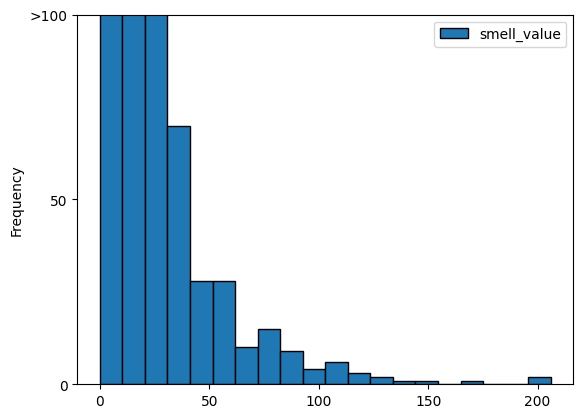

In [12]:
fig = df_smell.plot(kind="hist", bins=20, ylim=(0,100), edgecolor="black").set_yticks([0,50,100], labels=["0","50",">100"])

From the plot above, we can observe that a lot of the time, the smell values are fairly low. This means that smell events only happen occasionally, and thus our dataset is highly imbalanced.

We can also plot the average number of smell reports distributed by the day of week (Sunday to Saturday) and the hour of day (0 to 23), using the code below.

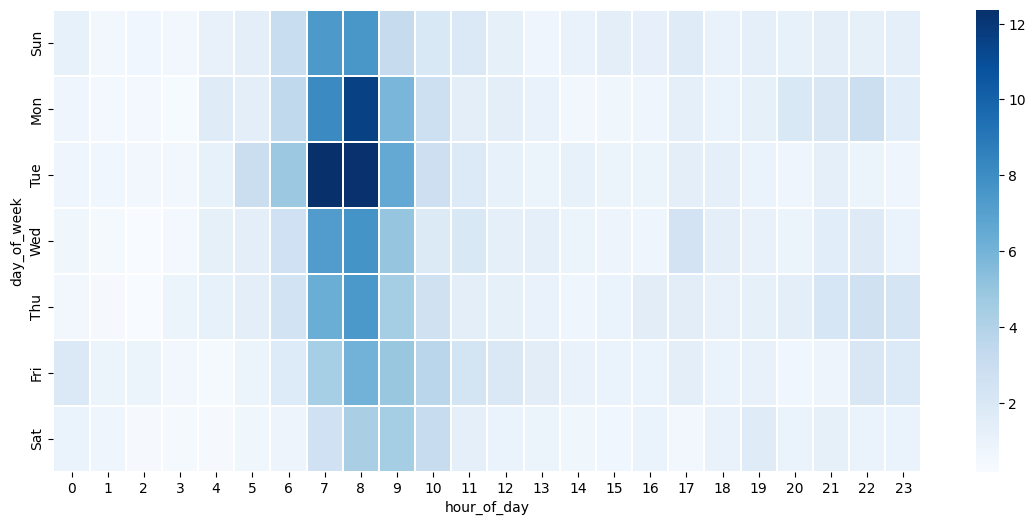

In [13]:
def is_datetime_obj_tz_aware(dt):
    """
    Find if the datetime object is timezone aware.
    
    Parameters
    ----------
    dt : pandas.DatetimeIndex
        A datatime index object.
    """
    return dt.tzinfo is not None and dt.tzinfo.utcoffset(dt) is not None


def plot_smell_by_day_and_hour(df):
    """
    Plot the average number of smell reports by the day of week and the hour of day.
    
    Parameters
    ----------
    df : pandas.DataFrame
        The preprocessed smell data.
    """
    # Copy the data frame to prevent editing the original one.
    df = df.copy(deep=True)
    
    # Convert timestamps to the local time in Pittsburgh.
    if is_datetime_obj_tz_aware(df.index):
        df.index = df.index.tz_convert(pytz.timezone("US/Eastern"))
    else:
        df.index = df.index.tz_localize(pytz.utc, ambiguous="infer").tz_convert(pytz.timezone("US/Eastern"))
    
    # Compute the day of week and the hour of day.
    df["day_of_week"] = df.index.dayofweek
    df["hour_of_day"] = df.index.hour
    
    # Plot the graph.
    y_l = ["Sun", "Mon", "Tue", "Wed", "Thu", "Fri", "Sat"]
    df_pivot = pd.pivot_table(df, values="smell_value", index=["day_of_week"], columns=["hour_of_day"], aggfunc=np.mean)
    f, ax = plt.subplots(figsize=(14, 6))
    sns.heatmap(df_pivot, annot=False, cmap="Blues", fmt="g", linewidths=0.1, yticklabels=y_l, ax=ax)
    
    
plot_smell_by_day_and_hour(df_smell)

From the plot above, we can observe that citizens tend to report smell in the morning.

## Task 6: Prepare Features and Labels

Now we have the preprocessed data in the `df_sensor` and `df_smell` variables. Our next task is to prepare features and labels for modeling, as shown in the figure below.

\
<img src="../../../assets/images/smellpgh-predict.png" style="max-width: 700px;">

\
Our goal is to construct two data frames, `df_x` and `df_y`, that represent the features and labels, respectively. First, we will deal with the sensor data. We need a function to insert columns that indicate previous `n_hr` hours of sensor to the existing data frame, where `n_hr` should be a parameter that we can control. The code below can help us achieve this.

In [14]:
def insert_previous_data_to_cols(df, n_hr=0):
    """
    This function is the answer of task 6 (part 1).
    Insert columns to indicate the data from the previous hours.
    
    Parameters
    ----------
    df : pandas.DataFrame
        The preprocessed sensor data.
    n_hr : int
        Number of hours that we want to insert the previous sensor data.
         
    Returns
    -------
    pandas.DataFrame
        The transformed sensor data.
    """
    # Copy data frame to prevent editing the original one.
    df = df.copy(deep=True)

    # Add the data from the previous hours.
    df_all = []
    for h in range(1, n_hr + 1):
        # Shift the data frame to get previous data.
        df_pre = df.shift(h)
        # Edit the name to indicate it is previous data.
        # The orginal data frame already has data from the previous 1 hour.
        # (as indicated in the preprocessing phase of sensor data)
        # So we need to add 1 here.
        df_pre.columns += "_pre_" + str(h+1) + "h"
        # Add the data to an array for merging.
        df_all.append(df_pre)

    # Rename the columns in the original data frame.
    # The orginal data frame already has data from the previous 1 hour.
    # (as indicated in the preprocessing phase of sensor data)
    df.columns += "_pre_1h"

    # Merge all data.
    df_merge = df
    for d in df_all:
        # The join function merges dataframes by index.
        df_merge = df_merge.join(d)
        
    # Delete the first n_hr rows.
    # These n_hr rows have no data due to data shifting.
    df_merge = df_merge.iloc[n_hr:]
    return df_merge

The code below shows a test case, which is a part of the sensor data.

In [15]:
# Below is an example input.
df_sensor_example_in = df_sensor[["3.feed_1.SONICWS_MPH"]][0:5]
df_sensor_example_in

,3.feed_1.SONICWS_MPH
EpochTime,
2016-10-31 06:00:00+00:00,3.6
2016-10-31 07:00:00+00:00,3.5
2016-10-31 08:00:00+00:00,3.4
2016-10-31 09:00:00+00:00,2.1
2016-10-31 10:00:00+00:00,2.2


In [16]:
# Below is the expected output of the above example input.
df_sensor_example_out = insert_previous_data_to_cols(df_sensor_example_in, n_hr=2)
df_sensor_example_out

,3.feed_1.SONICWS_MPH_pre_1h,3.feed_1.SONICWS_MPH_pre_2h,3.feed_1.SONICWS_MPH_pre_3h
EpochTime,,,
2016-10-31 08:00:00+00:00,3.4,3.5,3.6
2016-10-31 09:00:00+00:00,2.1,3.4,3.5
2016-10-31 10:00:00+00:00,2.2,2.1,3.4


The reason that there are 2 less rows in the expected output is because we set `n_hr=2`, which means there are missing data in the original first and second row (because there was no previous data for these rows). So in the code, we removed these rows.

Then, we also need a function to convert wind direction into sine and cosine components, which is a common technique for encoding cyclical features (i.e., any that that circulates within a set of values, such as hours of the day, days of the week). Below is the code for achieving this.

In [17]:
def convert_wind_direction(df):
    """
    Convert wind directions to sine and cosine components.
    
    Parameters
    ----------
    df : pandas.DataFrame
        The data frame that contains the wind direction data.
         
    Returns
    -------
    pandas.DataFrame
        The transformed data frame.
    """
    # Copy data frame to prevent editing the original one.
    df_cp = df.copy(deep=True)
    
    # Convert columns with wind directions.
    for c in df.columns:
        if "SONICWD_DEG" in c:
            df_c = df[c]
            df_c_cos = np.cos(np.deg2rad(df_c))
            df_c_sin = np.sin(np.deg2rad(df_c))
            df_c_cos.name += "_cosine"
            df_c_sin.name += "_sine"
            df_cp.drop([c], axis=1, inplace=True)
            df_cp[df_c_cos.name] = df_c_cos
            df_cp[df_c_sin.name] = df_c_sin
    return df_cp

The code below shows a test case, which is a part of the sensor data.

In [18]:
# Below is an example input.
df_wind_example_in = df_sensor[["3.feed_1.SONICWD_DEG"]][0:5]
df_wind_example_in

,3.feed_1.SONICWD_DEG
EpochTime,
2016-10-31 06:00:00+00:00,343.0
2016-10-31 07:00:00+00:00,351.0
2016-10-31 08:00:00+00:00,359.0
2016-10-31 09:00:00+00:00,5.0
2016-10-31 10:00:00+00:00,41.0


In [19]:
# Below is the expected output of the above example input.
df_wind_example_out = convert_wind_direction(df_wind_example_in)
df_wind_example_out

,3.feed_1.SONICWD_DEG_cosine,3.feed_1.SONICWD_DEG_sine
EpochTime,,
2016-10-31 06:00:00+00:00,0.956305,-0.292372
2016-10-31 07:00:00+00:00,0.987688,-0.156434
2016-10-31 08:00:00+00:00,0.999848,-0.017452
2016-10-31 09:00:00+00:00,0.996195,0.087156
2016-10-31 10:00:00+00:00,0.754710,0.656059


We have dealt with the sensor data. Next, we will deal with the smell data. We need a function to sum up smell values in the future hours, where `n_hr` should be a parameter that we can control. The code below shows a test case, which is a part of the smell data.

In [20]:
# Below is an example input.
df_smell_example_in = df_smell[107:112]
df_smell_example_in

,smell_value
EpochTime,
2016-11-05 10:00:00+00:00,8
2016-11-05 11:00:00+00:00,13
2016-11-05 12:00:00+00:00,40
2016-11-05 13:00:00+00:00,22
2016-11-05 14:00:00+00:00,4


In [21]:
# Below is the expected output of the above example input.
df_smell_example_out1 = answer_sum_current_and_future_data(df_smell_example_in, n_hr=1)
df_smell_example_out1

,smell_value
EpochTime,
2016-11-05 10:00:00+00:00,21.0
2016-11-05 11:00:00+00:00,53.0
2016-11-05 12:00:00+00:00,62.0
2016-11-05 13:00:00+00:00,26.0


In [22]:
# Below is another expected output with a different n_hr.
df_smell_example_out2 = answer_sum_current_and_future_data(df_smell_example_in, n_hr=3)
df_smell_example_out2

,smell_value
EpochTime,
2016-11-05 10:00:00+00:00,83.0
2016-11-05 11:00:00+00:00,79.0


In [23]:
# Below is another expected output when n_hr is 0.
df_smell_example_out3 = answer_sum_current_and_future_data(df_smell_example_in, n_hr=0)
df_smell_example_out3

,smell_value
EpochTime,
2016-11-05 10:00:00+00:00,8
2016-11-05 11:00:00+00:00,13
2016-11-05 12:00:00+00:00,40
2016-11-05 13:00:00+00:00,22
2016-11-05 14:00:00+00:00,4


<a name="a6"></a>

### Assignment for Task 6

**Your task (which is your assignment) is to write a function to do the following:**
- First, perform a [windowing operation](https://pandas.pydata.org/docs/user_guide/window.html#rolling-window-endpoints) to sum up smell values within a specified `n_hr` time window.
  - Hint: Use the `pandas.DataFrame.rolling` function when summing up values within a window. Type `?pd.DataFrame.rolling` in a code cell for more information.
  - Hint: Use the `pandas.DataFrame.shift` fuction to shift the rolled data back `n_hr` hours because we want to sum up the values in the future (the rolling function operates on the values in the past). Type `?pd.DataFrame.shift` in a code cell for more information.
- Finally, Remove the last `n_hr` hours of data because they have the wrong data due to shifting. For example, the last row does not have data in the future to operate if we set `n_hr=1`.
  - Hint: Use `pandas.DataFrame.iloc` to select the rows that you want to keep. Type `?pd.DataFrame.iloc` in a code cell for more information.
- You need to handle the edge case when `n_hr=0`, which should output the original data frame.

In [24]:
def sum_current_and_future_data(df, n_hr=0):
    """
    Sum up data in the current and future hours.
    
    Parameters
    ----------
    df : pandas.DataFrame
        The preprocessed smell data.
    n_hr : int
         Number of hours that we want to sum up the future smell data.
         
    Returns
    -------
    pandas.DataFrame
        The transformed smell data.
    """
    ###################################
    # Fill in your answer here
    return None
    ###################################

The code below tests if the output of your function matches the expected output.

In [25]:
check_answer_df(sum_current_and_future_data(df_smell_example_in, n_hr=1), df_smell_example_out1, n=1)

Test case 1 failed.

Your output is:
None

Expected output is:
                           smell_value
EpochTime                             
2016-11-05 10:00:00+00:00         21.0
2016-11-05 11:00:00+00:00         53.0
2016-11-05 12:00:00+00:00         62.0
2016-11-05 13:00:00+00:00         26.0


In [26]:
check_answer_df(sum_current_and_future_data(df_smell_example_in, n_hr=3), df_smell_example_out2, n=2)

Test case 2 failed.

Your output is:
None

Expected output is:
                           smell_value
EpochTime                             
2016-11-05 10:00:00+00:00         83.0
2016-11-05 11:00:00+00:00         79.0


In [27]:
check_answer_df(sum_current_and_future_data(df_smell_example_in, n_hr=0), df_smell_example_out3, n=3)

Test case 3 failed.

Your output is:
None

Expected output is:
                           smell_value
EpochTime                             
2016-11-05 10:00:00+00:00            8
2016-11-05 11:00:00+00:00           13
2016-11-05 12:00:00+00:00           40
2016-11-05 13:00:00+00:00           22
2016-11-05 14:00:00+00:00            4


Finally, we need a function to compute the features and labels, based on the above `insert_previous_data_to_cols` and `sum_current_and_future_data` functions that you implemented. The code is below.

In [28]:
def compute_feature_label(df_smell, df_sensor, b_hr_sensor=0, f_hr_smell=0):
    """
    Compute features and labels from the smell and sensor data.
    
    Parameters
    ----------
    df_smell : pandas.DataFrame
        The preprocessed smell data.
    df_sensor : pandas.DataFrame
        The preprocessed sensor data.
    b_hr_sensor : int
        Number of hours that we want to insert the previous sensor data.
    f_hr_smell : int
        Number of hours that we want to sum up the future smell data.
    
    Returns
    -------
    df_x : pandas.DataFrame
        The features that we want to use for modeling.
    df_y : pandas.DataFrame
        The labels that we want to use for modeling.
    """
    # Copy data frames to prevent editing the original ones.
    df_smell = df_smell.copy(deep=True)
    df_sensor = df_sensor.copy(deep=True)
    
    # Convert all wind directions.
    df_sensor = convert_wind_direction(df_sensor)
    
    # Insert previous sensor data as features.
    # Noice that the df_sensor is already using the previous data.
    # So b_hr_sensor=0 means using data from the previous 1 hour.
    # And b_hr_sensor=n means using data from the previous n+1 hours.
    df_sensor = insert_previous_data_to_cols(df_sensor, b_hr_sensor)
    
    # Sum up current and future smell values as label.
    # Notice that the df_smell is already the data from the future 1 hour.
    # (as indicated in the preprocessing phase of smell data)
    # So f_hr_smell=0 means using data from the future 1 hour.
    # And f_hr_smell=n means using data from the future n+1 hours.
    df_smell = answer_sum_current_and_future_data(df_smell, f_hr_smell)
    
    # Add suffix to the column name of the smell data to prevent confusion.
    # See the description above for the reason of adding 1 to the f_hr_smell.
    df_smell.columns += "_future_" + str(f_hr_smell+1) + "h"
    
    # We need to first merge these two timestamps based on the available data.
    # In this way, we synchronize the time stamps in the sensor and smell data.
    # This also means that the sensor and smell data have the same number of data points.
    df = pd.merge_ordered(df_sensor.reset_index(), df_smell.reset_index(), on=df_smell.index.name, how="inner", fill_method=None)
    
    # Sanity check: there should be no missing data.
    assert df.isna().sum().sum() == 0, "Error! There is missing data."
    
    # Separate features (x) and labels (y).
    df_x = df[df_sensor.columns]
    df_y = df[df_smell.columns]
    return df_x, df_y

We will use the sensor data within the previous 2 hours to predict bad smell within the future 2 hours. To use the `compute_feature_label` function that we just build, we need to set `b_hr_sensor=1` and `f_hr_smell=1` because originally `df_sensor` already contains data from the previous 1 hour, and `df_smell` already contains data from the future 1 hour. Note that `b_hr_sensor=n` means that we want to insert previous `n+1` hours of sensor data , and `f_hr_smell=m` means that we want to sum up the smell values of the future `m+1` hours. For example, suppose that the current time is 8:00, setting `b_hr_sensor=1` means that we use all sensor data from 6:00 to 8:00 (as features in prediction), and setting `f_hr_smell=1` means that we sum up the smell values from 8:00 to 10:00 (as labels in prediction).

In [29]:
df_x, df_y = compute_feature_label(df_smell, df_sensor, b_hr_sensor=1, f_hr_smell=1)

The features should look

In [30]:
df_x

,3.feed_1.SO2_PPM_pre_1h,3.feed_1.H2S_PPM_pre_1h,3.feed_1.SIGTHETA_DEG_pre_1h,3.feed_1.SONICWS_MPH_pre_1h,3.feed_23.CO_PPM_pre_1h,3.feed_23.PM10_UG_M3_pre_1h,3.feed_29.PM10_UG_M3_pre_1h,3.feed_29.PM25_UG_M3_pre_1h,3.feed_11067.CO_PPB..3.feed_43.CO_PPB_pre_1h,3.feed_11067.NO2_PPB..3.feed_43.NO2_PPB_pre_1h,...,3.feed_1.SONICWD_DEG_cosine_pre_2h,3.feed_1.SONICWD_DEG_sine_pre_2h,3.feed_11067.SONICWD_DEG..3.feed_43.SONICWD_DEG_cosine_pre_2h,3.feed_11067.SONICWD_DEG..3.feed_43.SONICWD_DEG_sine_pre_2h,3.feed_28.SONICWD_DEG_cosine_pre_2h,3.feed_28.SONICWD_DEG_sine_pre_2h,3.feed_26.SONICWD_DEG_cosine_pre_2h,3.feed_26.SONICWD_DEG_sine_pre_2h,3.feed_3.SONICWD_DEG_cosine_pre_2h,3.feed_3.SONICWD_DEG_sine_pre_2h
0,0.0,0.0,17.4,2.6,0.2,7.0,10.0,6.0,207.8,6.7,...,0.258819,0.965926,0.139173,0.990268,0.573576,0.819152,0.788011,0.615661,0.325568,0.945519
1,0.0,0.0,18.5,2.4,0.2,8.0,18.0,7.0,314.6,13.3,...,0.515038,0.857167,0.069756,0.997564,0.374607,0.927184,0.629320,0.777146,0.342020,0.939693
2,0.0,0.0,51.3,1.8,0.3,14.0,15.0,8.0,307.9,15.4,...,0.766044,0.642788,0.241922,0.970296,0.484810,0.874620,0.961262,0.275637,0.325568,0.945519
3,0.0,0.0,35.7,1.8,0.3,11.0,12.0,8.0,178.3,10.8,...,0.999391,0.034899,0.422618,0.906308,0.939693,0.342020,0.990268,0.139173,0.422618,0.906308
4,0.0,0.0,56.2,1.7,0.3,13.0,9.0,5.0,190.7,7.2,...,0.190809,0.981627,0.207912,0.978148,0.719340,0.694658,0.939693,0.342020,0.422618,0.906308
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16752,0.0,0.0,57.0,2.0,0.1,12.0,20.0,5.0,679.4,7.9,...,0.987688,-0.156434,0.939693,0.342020,0.573576,-0.819152,0.731354,-0.681998,0.241922,-0.970296
16753,0.0,0.0,32.0,1.9,0.2,12.0,12.0,8.0,680.2,9.6,...,0.920505,0.390731,0.669131,0.743145,0.069756,-0.997564,0.798636,-0.601815,0.906308,0.422618
16754,0.0,0.0,35.2,1.7,0.3,20.0,15.0,10.0,455.1,8.2,...,0.544639,0.838671,-0.829038,0.559193,0.500000,-0.866025,0.987688,-0.156434,0.358368,0.933580
16755,0.0,0.0,48.2,1.3,0.3,25.0,19.0,12.0,761.2,11.5,...,0.777146,0.629320,-0.173648,0.984808,0.224951,0.974370,1.000000,0.000000,0.777146,0.629320


In [31]:
df_y

,smell_value_future_2h
0,3.0
1,0.0
2,0.0
3,0.0
4,5.0
...,...
16752,3.0
16753,3.0
16754,0.0
16755,0.0


## Task 7: Train and Evaluate Models